In [ ]:
import sys
import math
sys.path.append("../../..")

import matplotlib.pyplot as plt
import numpy as np
import cv2

from src.core.dto import VisualCheckStatus, VisualCheckResult, Detection
from src.adapters.verifiers.windowed import WindowedVisualVerifier
from src.app.parsers import parse_verifier, parse_detector, parse_camera, parse_checkout_input
from src.app.factories import build_camera, build_detector, build_checkout_input

In [92]:
camera_config = {
    "type": "opencv",
    "source": 0,
}
camera_config_object = parse_camera(camera_config)
camera = build_camera(camera_config_object)
camera.open()

In [93]:
detector_config = {
    "type": "yolo",
    "weights_path": "../../../weights/best.pt",
    "classes": [
        "apple",
        "cucumber",
        "grape",
        "kiwi",
        "lemon",
        "orange",
        "pear",
        "pineapple",
        "potato",
        "tomato",
        "watermelon",
    ],
    "confidence_threshold": 0.4,
    "iou_threshold": 0.2,
    "device": "cpu"
}
detector_config_object = parse_detector(detector_config)
detector = build_detector(detector_config_object)

In [ ]:
checkout_input_config = {
    "type": "mock",
    "requests": [
        {
            "sku": "0001",
            "label": "apple",
        },
    ],
}
checkout_input_config_object = parse_checkout_input(checkout_input_config)
checkout_input = build_checkout_input(checkout_input_config_object)

In [ ]:
verifier_config = {
    "type": "windowed",
    "window_size": 0.5,
    "thresholds": {
        "confidence": 0.5,
        "detections": 1,
    }
}
verifier_config_object = parse_verifier(verifier_config)
verifier = WindowedVisualVerifier(verifier_config_object, classes=detector_config_object.classes)

In [ ]:
request = checkout_input.get_request()
request

CheckoutRequest(sku='0001', label='apple')

In [ ]:
items: list[tuple[np.ndarray, Detection]] = []

result = VisualCheckResult(status=VisualCheckStatus.PENDING)
while result.status == VisualCheckStatus.PENDING:
    frame = camera.read()
    detections = detector.detect(frame)

    items.append((frame, detections))

    result = verifier.verify(
        detections=detections,
        request=request,
    )

In [ ]:
result

VisualCheckResult(status=<VisualCheckStatus.MATCH: 'match'>, confidence=0.774778813123703, detected_label='apple')

In [ ]:
def draw_detections(
    frame: np.ndarray, 
    detections: list[Detection],
    classes: dict[int, str],
) -> np.ndarray:
    img = frame.copy()

    for det in detections:
        x1, y1, x2, y2 = det.bbox

        label = classes.get(det.class_id)
        confidence = det.confidence

        text = f"{label} {confidence:.2f}"

        cv2.rectangle(
            img,
            (x1, y1),
            (x2, y2),
            color=(255, 0, 0),
            thickness=2,
        )

        (text_w, text_h), baseline = cv2.getTextSize(
            text,
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.7,
            thickness=1,
        )

        cv2.rectangle(
            img,
            (x1, y1 - text_h - baseline - 4),
            (x1 + text_w + 4, y1),
            color=(255, 0, 0),
            thickness=-1,
        )

        cv2.putText(
            img,
            text,
            (x1 + 2, y1 - baseline - 2),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.7,
            color=(255, 255, 255),
            thickness=2,
            lineType=cv2.LINE_AA,
        )

    return img

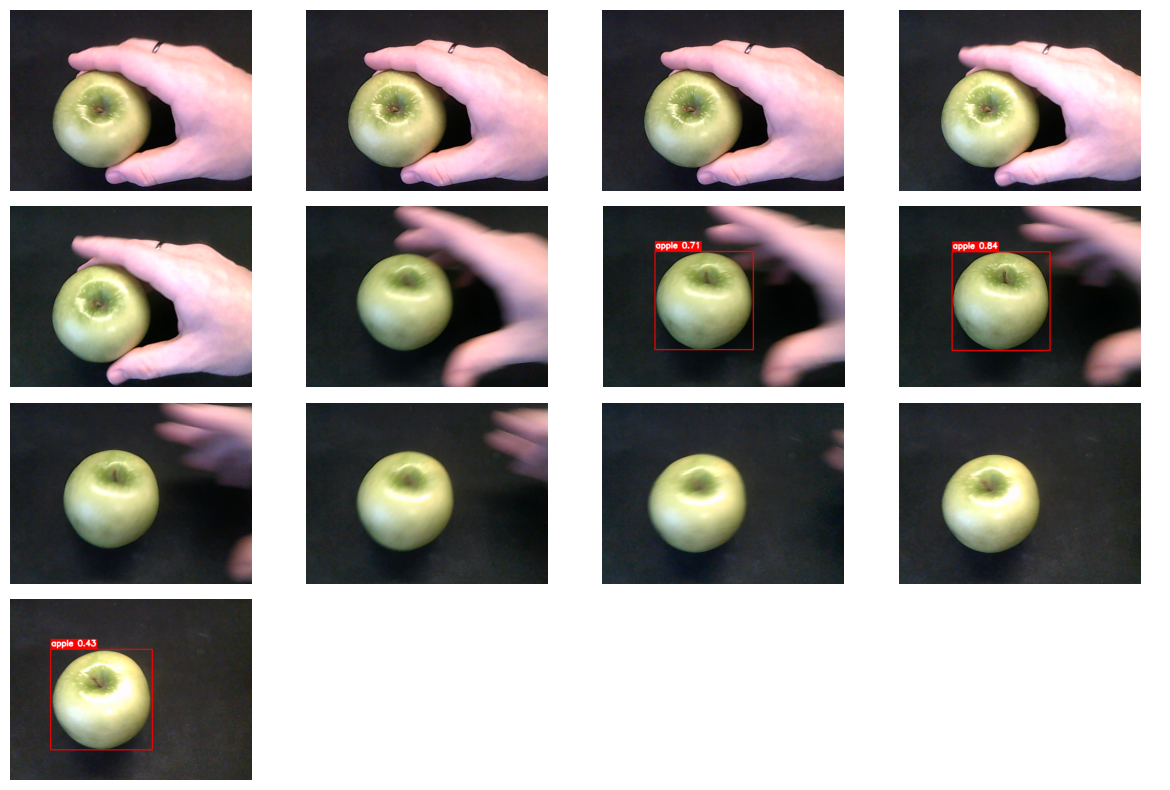

In [113]:
n = len(items)

ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=(ncols * 3, nrows * 2),
)

axes = axes.flatten() if n > 1 else [axes]

for ax, (frame, detections) in zip(axes, items):
    img = draw_detections(frame, detections, detector_config_object.classes)
    ax.imshow(img)

for ax in axes:
    ax.axis("off")

plt.tight_layout()